In [59]:
# Necessary imports
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [60]:
from torchvision import transforms
# Dataset loading 
path_to_images = './dataset/'
transform = transforms.Compose([
    transforms.ToTensor()
])
MNIST_dataset = torchvision.datasets.MNIST(
    root = path_to_images,
    train = True,
    transform = transform,
    download = True
)
MNIST_test_dataset = torchvision.datasets.MNIST(
    root = path_to_images,
    train = False,
    transform = transform,
    download = True
)


In [61]:
# Split train set on train and dev sets
from torch.utils.data import random_split
emnist_train_dataset, emnist_dev_dataset = random_split(MNIST_dataset, [50000,10000])


In [62]:
# Choose batchsize and creates DataLoaders for model
from torch.utils.data import DataLoader
batch_size = 512
dl_train = DataLoader(emnist_train_dataset,
                      batch_size,
                      shuffle = True)
dl_dev = DataLoader(emnist_dev_dataset,
                      batch_size,
                      shuffle = False)


## Model

Conv-ReLU-MaxPool-Conv-ReLU-MaxPool-FC1-FC2

In [63]:
model = nn.Sequential()
model.add_module(
    'Convolution1',
    nn.Conv2d(
        in_channels = 1, out_channels = 6,
        kernel_size = 3, padding = 1
    )
)
model.add_module('ReLU1', nn.ReLU())
model.add_module('MaxPool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'Convolution2',
    nn.Conv2d(
        in_channels = 6, out_channels = 16,
        kernel_size = 5, padding = 2
    )
)
model.add_module('ReLU2',
                 nn.ReLU()
                 )
model.add_module('MaxPool2',
                 nn.MaxPool2d(kernel_size=2)
                )
model.add_module('Flat',
                 nn.Flatten()
                 )
model.add_module('FC1',
                 nn.Linear(784,256)
                 )
model.add_module('ReLU3',
                 nn.ReLU()
                 )
model.add_module('FC2', 
                 nn.Linear(256,10)
                 )

In [86]:
# sanity check for model
x = torch.ones(512,1,28,28)
model(x).shape

torch.Size([512, 10])

In [65]:
# Choose loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.003, weight_decay=0.005)


In [66]:
# Trains model for number of epochs
# Also creates lists for future plots
def train(model, train, dev, epochs):
    loss_train = [0 for _ in range(epochs)]
    acc_train = [0 for _ in range(epochs)]
    loss_dev = [0 for _ in range(epochs)]
    acc_dev = [0 for _ in range(epochs)]
    for i in range(epochs):
        model.train()
        for x, y in dl_train:
            prediction = model(x)
            loss = loss_func(prediction, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_train[i] += loss.item()*y.size(0)
            acc_train[i] += (torch.argmax(prediction, dim=1) == y).float().sum()
        model.eval()
        with torch.no_grad():
            for x, y in dl_dev:
                prediction = model(x)
                loss = loss_func(prediction, y)
                loss_dev[i] += loss.item()*y.size(0)
                acc_dev[i] += (torch.argmax(prediction, dim=1) == y).float().sum()
        for el in [loss_train, acc_train]:
            el[i] /= len(dl_train.dataset)
        for el in [loss_dev, acc_dev]:
            el[i] /= len(dl_dev.dataset)
    
        print(f'Epoch {i+1}, train: {acc_train[i]}, dev: {acc_dev[i]}')
    
    return loss_train, acc_train, loss_dev, acc_dev

In [67]:
plots = train(model, dl_train, dl_dev, 10)

Epoch 1, train: 0.8303999900817871, dev: 0.9413999915122986
Epoch 2, train: 0.9625800251960754, dev: 0.9706000089645386
Epoch 3, train: 0.9753599762916565, dev: 0.9751999974250793
Epoch 4, train: 0.9818400144577026, dev: 0.9797999858856201
Epoch 5, train: 0.9847800135612488, dev: 0.9825999736785889
Epoch 6, train: 0.9878600239753723, dev: 0.9847000241279602
Epoch 7, train: 0.9894800186157227, dev: 0.986299991607666
Epoch 8, train: 0.991320013999939, dev: 0.9832000136375427
Epoch 9, train: 0.9915800094604492, dev: 0.986299991607666
Epoch 10, train: 0.9934800267219543, dev: 0.9883999824523926


In [68]:
prediction = model(MNIST_test_dataset.data.unsqueeze(1)/255.0)
test_acc = (torch.argmax(prediction, dim = 1) == MNIST_test_dataset.targets).float().sum()
print(f"Test accuracy: {test_acc/len(MNIST_test_dataset.targets)}")


Test accuracy: 0.9904000163078308


Text(0.5, 1.0, 'Loss over epochs')

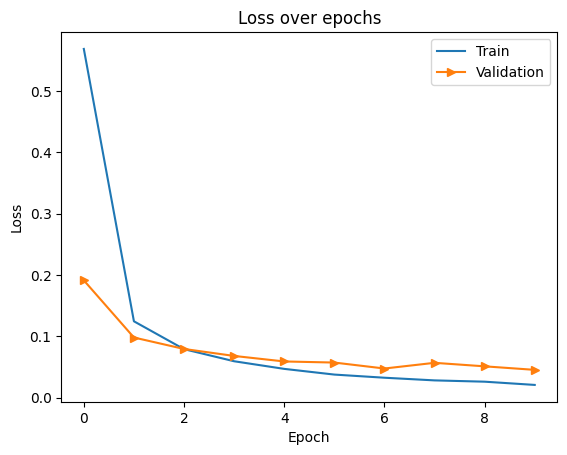

In [84]:
figure = plt.figure()
plt.plot([i for i in range(10)], plots[0],'-')
plt.plot([i for i in range(10)], plots[2], '->')
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')

In [85]:
torch.save(model, './models/final_model.pt')